In [1]:
import gc
import time

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import utils

%matplotlib inline

PRETRAIN_FILE_NAME = './weights/test_pretrain2'

In [2]:
n_steps = 5
n_d = 8
gamma = 1.5
emb_dim = 1

In [3]:
df = pd.read_csv('data/processed_train.csv')
df_test = pd.read_csv('data/processed_test.csv')

In [4]:
CALC_COLUMNS = [col for col in df.columns if 'calc' in col]

df.drop(CALC_COLUMNS, axis=1, inplace=True)
df_test.drop(CALC_COLUMNS, axis=1, inplace=True)
len(df.columns)

39

In [5]:
CATEGORICAL_COLUMNS = [col for col in df.columns if col.endswith('bin') or col.endswith('cat')]
NUMERIC_COLUMNS = [col for col in df.columns if not col.endswith('bin') and not col.endswith('cat')]

# not include low cardinality (<= 3) categorical features
# CATEGORICAL_COLUMNS = [col for col in df.columns if col.endswith('cat')]
# NUMERIC_COLUMNS = [col for col in df.columns if not col.endswith('cat')]
# for col in ['ps_ind_04_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 
#             'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_10_cat']:
#     CATEGORICAL_COLUMNS.remove(col)
#     NUMERIC_COLUMNS.append(col)

NUMERIC_COLUMNS.remove('id')
NUMERIC_COLUMNS.remove('target')

In [6]:
utils.cast_save_memmory(df, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS)
utils.cast_save_memmory(df_test, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS)

In [7]:
categorical_dims =  {}
for col in CATEGORICAL_COLUMNS:
    categorical_dims[col] = df[col].nunique()   

In [8]:
df = df.append(df_test)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(df[NUMERIC_COLUMNS + CATEGORICAL_COLUMNS], 
                                                      df['target'], train_size=0.8, random_state=42)

In [10]:
features = [col for col in X_train.columns] 

cat_idxs = [i for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]

In [11]:
del df, df_test
gc.collect()

64

In [12]:
unsupervised_model = TabNetPretrainer(n_steps=n_steps,
                       n_d=n_d, 
                       n_a=n_d, 
                       gamma=gamma,
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=emb_dim,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2.5e-2),
                       mask_type='entmax'
)

unsupervised_model.fit(
    X_train=X_train.values,
    eval_set=[X_valid.values],
    max_epochs=100 , patience=5,
    batch_size=5000, virtual_batch_size=250,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.33,
)

Device used : cpu
epoch 0  | loss: 143686.95108| val_0_unsup_loss: 0.89031 |  0:01:57s
epoch 1  | loss: 4381.54173| val_0_unsup_loss: 0.74494 |  0:03:52s
epoch 2  | loss: 6929.40327| val_0_unsup_loss: 0.69443 |  0:05:53s
epoch 3  | loss: 3603.35929| val_0_unsup_loss: 0.72328 |  0:08:09s
epoch 4  | loss: 4336.16926| val_0_unsup_loss: 0.70544 |  0:10:11s
epoch 5  | loss: 5526.44079| val_0_unsup_loss: 0.68559 |  0:12:05s
epoch 6  | loss: 7846.75097| val_0_unsup_loss: 0.68399 |  0:14:00s
epoch 7  | loss: 7217.98821| val_0_unsup_loss: 0.68703 |  0:15:58s
epoch 8  | loss: 16034.90487| val_0_unsup_loss: 0.67113 |  0:17:59s
epoch 9  | loss: 7814.87674| val_0_unsup_loss: 0.66897 |  0:19:59s
epoch 10 | loss: 5527.1335| val_0_unsup_loss: 0.74376 |  0:21:59s
epoch 11 | loss: 12453.43459| val_0_unsup_loss: 0.65955 |  0:24:04s
epoch 12 | loss: 13160.35175| val_0_unsup_loss: 0.64806 |  0:26:08s
epoch 13 | loss: 11713.42197| val_0_unsup_loss: 0.6556  |  0:28:06s
epoch 14 | loss: 19638.21263| val_0_uns

KeyboardInterrupt: 

In [13]:
unsupervised_model.save_model(PRETRAIN_FILE_NAME)

Successfully saved model at ./weights/test_pretrain2.zip


'./weights/test_pretrain2.zip'

In [14]:
df = pd.read_csv('data/processed_train.csv')
df.drop(CALC_COLUMNS, axis=1, inplace=True)
utils.cast_save_memmory(df, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS)

df_test = pd.read_csv('data/processed_test.csv')
df_test.drop(CALC_COLUMNS, axis=1, inplace=True)
utils.cast_save_memmory(df_test, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS)

In [15]:
kf = KFold(n_splits=5, shuffle=True)

i = 0
for train_index, valid_index in kf.split(df):
    print(f'{i} fold')
    X_train = df.loc[train_index, NUMERIC_COLUMNS + CATEGORICAL_COLUMNS]
    X_valid = df.loc[valid_index, NUMERIC_COLUMNS + CATEGORICAL_COLUMNS]
    y_train = df.loc[train_index, 'target']
    y_valid = df.loc[valid_index, 'target']
    
    loaded_pretrain = TabNetPretrainer()
    loaded_pretrain.load_model(PRETRAIN_FILE_NAME + '.zip')

    clf = TabNetClassifier(n_steps=n_steps,
                       n_d=n_d, 
                       n_a=n_d, 
                       gamma=gamma,
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=emb_dim,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       mask_type='entmax'
                      )

    clf.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=100 , patience=5,
        batch_size=10000, virtual_batch_size=250,
        num_workers=0,
        weights=1,
        drop_last=False,
        from_unsupervised=loaded_pretrain
    )
    
    y_pred = clf.predict_proba(df_test[NUMERIC_COLUMNS + CATEGORICAL_COLUMNS].values)
    sol = pd.read_csv('solutions/scaled_benchmark_mix_8.csv')
    sol.iloc[:, 1] = y_pred[:, 1]
    sol.to_csv(f'solutions/tabnet_pretr_{n_steps}_{n_d}_{int(gamma*10)}_{emb_dim}_f_{i}_1.csv', index=False)
    i += 1
    time.sleep(60*5)

0 fold
Device used : cpu
Device used : cpu
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.682   | train_auc: 0.60434 | valid_auc: 0.60293 |  0:00:49s
epoch 1  | loss: 0.67187 | train_auc: 0.62219 | valid_auc: 0.62016 |  0:01:39s
epoch 2  | loss: 0.66812 | train_auc: 0.63014 | valid_auc: 0.62689 |  0:02:28s
epoch 3  | loss: 0.66523 | train_auc: 0.63761 | valid_auc: 0.62843 |  0:03:18s
epoch 4  | loss: 0.66306 | train_auc: 0.64243 | valid_auc: 0.63274 |  0:04:08s
epoch 5  | loss: 0.66122 | train_auc: 0.64815 | valid_auc: 0.63179 |  0:04:57s
epoch 6  | loss: 0.65993 | train_auc: 0.65058 | valid_auc: 0.63166 |  0:05:47s
epoch 7  | loss: 0.65779 | train_auc: 0.65562 | valid_auc: 0.6293  |  0:06:37s
epoch 8  | loss: 0.65586 | train_auc: 0.65855 | valid_auc: 0.62768 |  0:07:27s
epoch 9  | loss: 0.65382 | train_auc: 0.66038 | valid_auc: 0.62711 |  0:08:17s

Early stopping occurred at epoch 9 with best_epoch = 4 and best_valid_auc = 0.63274
Best weights from 

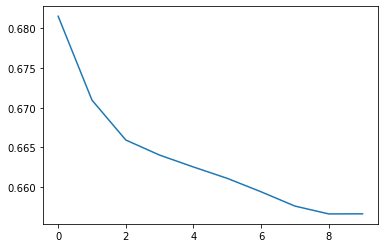

In [16]:
# plot losses
plt.plot(clf.history['loss'])

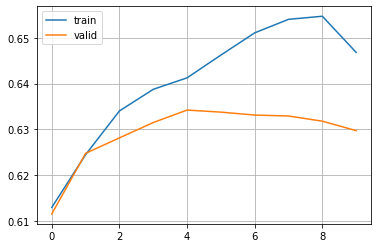

In [17]:
# plot auc
plt.plot(clf.history['train_auc'], label='train')
plt.plot(clf.history['valid_auc'], label='valid')
plt.legend()
plt.grid();

In [18]:
imp = pd.DataFrame({'imp': clf.feature_importances_, 'name': features}).sort_values(by='imp')
imp.to_csv(f'data/importance_{n_steps}_{n_d}_{int(gamma*10)}_{emb_dim}', index=False)
imp

,imp,name
29,0.000000e+00,ps_car_04_cat
4,0.000000e+00,ps_reg_01
27,0.000000e+00,ps_car_02_cat
10,0.000000e+00,ps_car_14
11,0.000000e+00,ps_car_15
1,4.700390e-08,ps_ind_03
26,1.698993e-07,ps_car_01_cat
35,9.807421e-07,ps_car_10_cat
22,9.047268e-06,ps_ind_13_bin
0,1.275034e-05,ps_ind_01
